# Classification - Etape 2 - Régime pluviométrique selon classification Koppen

# 1. Import des package

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

C:\Users\julie\anaconda3\envs\geo_env\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# 2. Création du dataset de séries temporelles de précipitations

In [2]:
df=pd.read_csv('weatherAUS_Imputer.csv')
df.head()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Rain_J-2,Rain_J+2,Rain_J+3,Mois_cos,Mois_sin,clim_méditerranéen,clim_océanique,clim_sec,clim_subtropical,clim_tropical
0,96322,6.2,15.1,0.0,1.80,2.1,20.0,2.0,11.0,81.0,...,1.0,0.0,0.0,-1.0,1.224647e-16,1,0,0,0,0
1,96323,5.3,15.9,0.0,1.40,8.0,30.0,6.0,13.0,71.0,...,0.0,0.0,1.0,-1.0,1.224647e-16,1,0,0,0,0
2,96324,9.8,15.4,0.0,2.80,0.9,30.0,9.0,9.0,56.0,...,0.0,1.0,1.0,-1.0,1.224647e-16,1,0,0,0,0
3,96325,11.3,15.7,8.1,1.64,1.5,52.0,15.0,22.0,62.0,...,0.0,1.0,1.0,-1.0,1.224647e-16,1,0,0,0,0
4,96326,7.6,11.2,16.2,4.60,1.1,46.0,17.0,13.0,83.0,...,0.0,1.0,1.0,-1.0,1.224647e-16,1,0,0,0,0


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df_class=df[['Date','Rainfall','Location','Climat_Koppen']]

In [5]:
df_class.head()

,Date,Rainfall,Location,Climat_Koppen
0,2008-07-03,0.0,Adelaide,Csa
1,2008-07-04,0.0,Adelaide,Csa
2,2008-07-05,0.0,Adelaide,Csa
3,2008-07-06,8.1,Adelaide,Csa
4,2008-07-07,16.2,Adelaide,Csa


In [6]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145455 entries, 0 to 145454
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145455 non-null  datetime64[ns]
 1   Rainfall       145455 non-null  float64       
 2   Location       145455 non-null  object        
 3   Climat_Koppen  145455 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.4+ MB


## Récupération de la liste des villes

In [7]:
locations= df_class.Location.drop_duplicates().to_list()

## Filtre sur la plus grande période contenant autant de données pour chacune des villes.

In [8]:
mask = (df_class['Date'] >= '2014-01-01') & (df_class['Date'] <= '2017-06-22')
filtered_df_class=df_class.loc[mask]
filtered_df_class.head()

,Date,Rainfall,Location,Climat_Koppen
1919,2014-01-01,2.1,Adelaide,Csa
1920,2014-01-02,4.2,Adelaide,Csa
1921,2014-01-03,0.8,Adelaide,Csa
1922,2014-01-04,0.6,Adelaide,Csa
1923,2014-01-05,1.7,Adelaide,Csa


In [9]:
filtered_df_class.tail()

,Date,Rainfall,Location,Climat_Koppen
145450,2017-06-18,0.0,Woomera,Bwh
145451,2017-06-19,0.0,Woomera,Bwh
145452,2017-06-20,0.0,Woomera,Bwh
145453,2017-06-21,0.0,Woomera,Bwh
145454,2017-06-22,0.0,Woomera,Bwh


## La 2ème lettre des types de Climat Koppen correspond au régime pluviométrique
### Création d'une nouvelle colonne correspondant à cette lettre
#

In [10]:
filtered_df_class['Climat_Koppen_2L']=filtered_df_class['Climat_Koppen'].str[1]
filtered_df_class

C:\Users\julie\AppData\Local\Temp\ipykernel_14188\2848709495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_class['Climat_Koppen_2L']=filtered_df_class['Climat_Koppen'].str[1]


,Date,Rainfall,Location,Climat_Koppen,Climat_Koppen_2L
1919,2014-01-01,2.1,Adelaide,Csa,s
1920,2014-01-02,4.2,Adelaide,Csa,s
1921,2014-01-03,0.8,Adelaide,Csa,s
1922,2014-01-04,0.6,Adelaide,Csa,s
1923,2014-01-05,1.7,Adelaide,Csa,s
...,...,...,...,...,...
145450,2017-06-18,0.0,Woomera,Bwh,w
145451,2017-06-19,0.0,Woomera,Bwh,w
145452,2017-06-20,0.0,Woomera,Bwh,w
145453,2017-06-21,0.0,Woomera,Bwh,w


## Visualisation de la distribution des régimes pluviométiques

C:\Users\julie\anaconda3\envs\geo_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


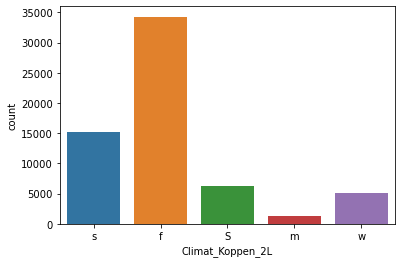

In [11]:
sns.countplot(filtered_df_class.Climat_Koppen_2L);

## Récupération des régimes pluviométriques Climat Koppen 

In [12]:
labels=filtered_df_class.Climat_Koppen_2L.drop_duplicates().to_list()
labels

['s', 'f', 'S', 'm', 'w']

## Création du dataset pour le clustering des times series de températures moyennes

In [13]:
le=LabelEncoder()
le.fit(labels)
labels=np.array(le.transform(labels))
labels

array([3, 1, 0, 2, 4])

## Création des séries temporelles

In [14]:
x = np.array(filtered_df_class.Rainfall)
x

array([2.1, 4.2, 0.8, ..., 0. , 0. , 0. ])

In [15]:
len(x)

62181

In [16]:
x = x.reshape(49,1269)
x

array([[ 2.1,  4.2,  0.8, ...,  0. ,  0. ,  0. ],
       [ 0.2,  0.4,  0. , ...,  8.8, 14.5, 20.2],
       [ 0. ,  0. ,  0.2, ...,  0.2,  0.4,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  4. ,  5. , 13.6],
       [ 0. ,  0. ,  0.2, ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

In [17]:
len(x[0])

1269

In [18]:
x_train = x.reshape((x.shape[0], x.shape[1], 1))
x_train

array([[[ 2.1],
        [ 4.2],
        [ 0.8],
        ...,
        [ 0. ],
        [ 0. ],
        [ 0. ]],

       [[ 0.2],
        [ 0.4],
        [ 0. ],
        ...,
        [ 8.8],
        [14.5],
        [20.2]],

       [[ 0. ],
        [ 0. ],
        [ 0.2],
        ...,
        [ 0.2],
        [ 0.4],
        [ 0. ]],

       ...,

       [[ 0. ],
        [ 0. ],
        [ 0. ],
        ...,
        [ 4. ],
        [ 5. ],
        [13.6]],

       [[ 0. ],
        [ 0. ],
        [ 0.2],
        ...,
        [ 0. ],
        [ 0. ],
        [ 0. ]],

       [[ 0. ],
        [ 0. ],
        [ 0. ],
        ...,
        [ 0. ],
        [ 0. ],
        [ 0. ]]])

In [19]:
len(x_train)

49

In [20]:
num_classes=2*labels.shape[0]
seed = 0
sz = x_train.shape[1]

In [21]:
max_y=df['Rainfall'].max()

# 3. Utilisation de tslearn et de l'algoritme TimeSeriesKmeans / Metric dtw

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

2455.921 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.6s finished


1825.911 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1825.911 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

2524.464 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished


1978.398 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.6s finished


1951.445 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.8s finished


1951.445 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

2529.564 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.6s finished


1970.452 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1951.673 --> 

[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.6s finished


1951.673 --> 
Init 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

2454.717 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.8s finished


1859.836 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1774.962 --> 

[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1774.962 --> 
Init 5


[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

2490.088 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.4s finished


1754.034 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1737.062 --> 

[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished


1737.062 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Init 6
2524.996 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1822.534 --> 

[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished


1822.534 --> 
Init 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

2506.287 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished


1821.038 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.9s finished


1760.027 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.6s finished


1760.027 --> 
Init 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

2489.476 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.8s finished


1921.179 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.9s finished


1921.179 --> 
Init 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

2750.008 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.8s finished


1907.804 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.7s finished


1898.003 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1893.856 --> 

[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1893.856 --> 
Init 10


[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

2535.726 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished


1856.780 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished


1828.452 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1824.008 --> 

[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1824.008 --> 


[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.5s finished


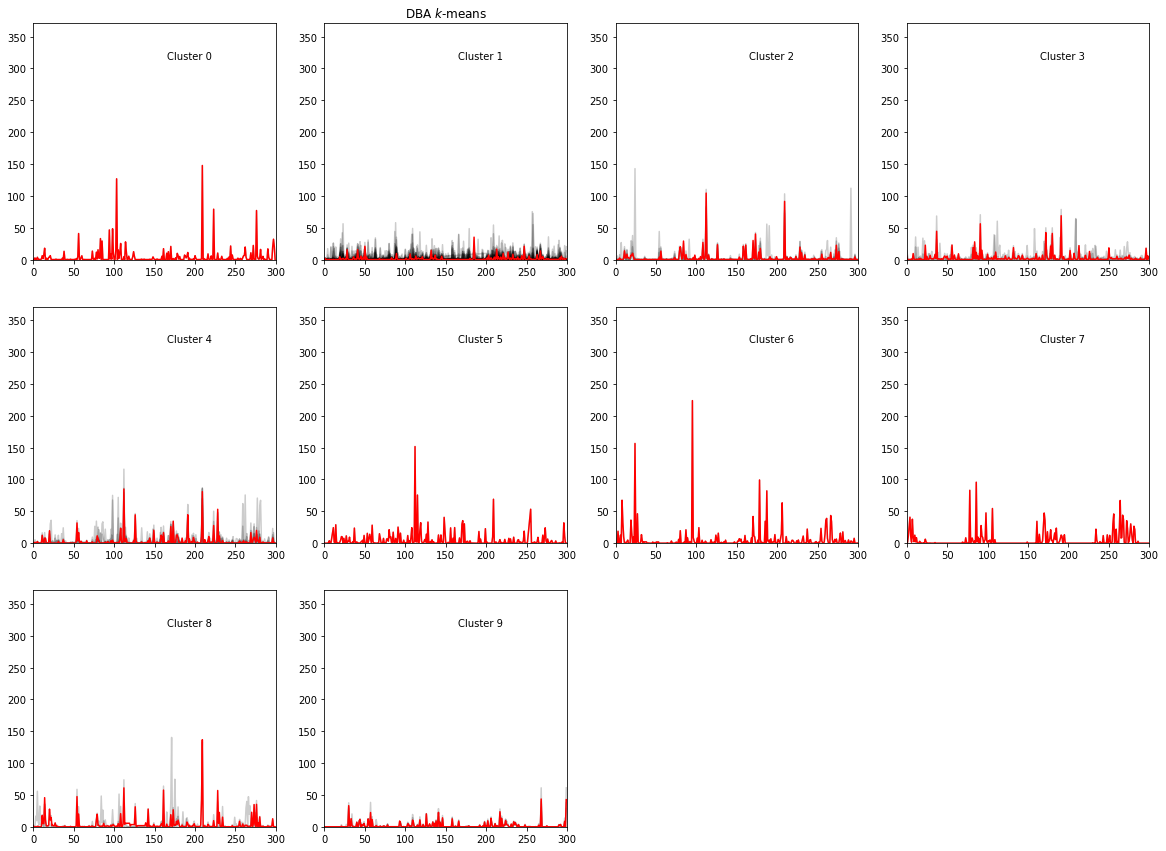

In [22]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=num_classes,
                          n_init=10,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=100,
                          random_state=seed)
x_train=TimeSeriesResampler(sz=300).fit_transform(x_train)
y_pred_dba = dba_km.fit_predict(x_train)

plt.figure(figsize=(20,20))

for yi in range(num_classes):
    plt.subplot(4, 4, 1 + yi)
    for xx in x_train[y_pred_dba == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 300)
    plt.ylim(0, max_y)
    plt.text(0.55, 0.85,'Cluster %d' % (yi ),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")



# 4. Synthèse des résultats 


In [23]:
results=pd.DataFrame({'Location':locations,'Clusters':y_pred_dba.astype(str)})
climatsaus = pd.read_csv("climatsAUS_v2.csv",sep=";")
results = pd.merge(results, climatsaus, how='left', left_on="Location",right_on="Location")

In [24]:
results['Climat_Koppen_2L']=results['Climat_Koppen'].str[1]

In [25]:
results

,Location,Clusters,Climat_Koppen,Climat_Koppen_2L
0,Adelaide,1,Csa,s
1,Albany,1,Csb,s
2,Albury,1,Cfa,f
3,AliceSprings,1,BSh,S
4,BadgerysCreek,2,Cfa,f
5,Ballarat,1,Cfb,f
6,Bendigo,1,Cfb,f
7,Brisbane,4,Cfa,f
8,Cairns,6,Am,m
9,Canberra,1,Cfb,f


In [26]:
table_dba = pd.crosstab(results['Climat_Koppen_2L'], results['Clusters'])

In [27]:
table_dba

Clusters,0,1,2,3,4,5,6,7,8,9
Climat_Koppen_2L,,,,,,,,,,
S,0,5,0,0,0,0,0,0,0,0
f,1,13,3,3,5,1,0,0,1,0
m,0,0,0,0,0,0,1,0,0,0
s,0,9,0,0,0,0,0,0,0,3
w,0,1,1,0,0,0,0,1,1,0


# 5. Visualisations des climats pour chacune des villes

In [28]:
aus_town_gps = pd.read_csv("aus_town_gps.csv",sep=",")
aus_town_gps
results = pd.merge(results, aus_town_gps, how='left', left_on="Location",right_on="Location")

In [29]:
geometry = [Point(xy) for xy in zip(results['Longitude'], results['Latitude'])]
geo_df = gpd.GeoDataFrame(results, geometry=geometry)

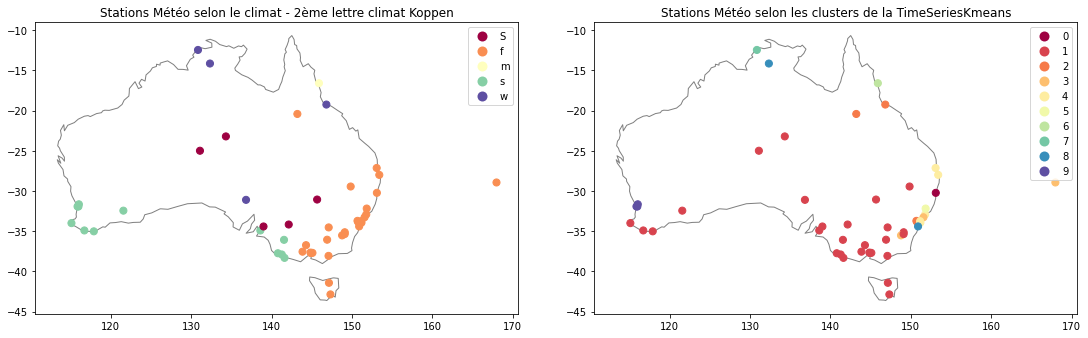

In [30]:
Contour_Aus = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Contour_Aus = Contour_Aus[Contour_Aus["name"] == "Australia"]

fig = plt.figure(constrained_layout=True, figsize=(15, 15))
subfigs = fig.subfigures(1, 2, wspace=0.07)

ax=subfigs[0].subplots(1, 1)
Contour_Aus.plot(ax=ax,color="None",edgecolor="Grey")  
ax.title.set_text('Stations Météo selon le climat - 2ème lettre climat Koppen')
geo_df.plot(ax=ax,markersize=50, cmap='Spectral', column="Climat_Koppen_2L",legend=True);

ax1=subfigs[1].subplots(1, 1)
Contour_Aus.plot(ax=ax1,color="None",edgecolor="Grey")  
ax1.title.set_text('Stations Météo selon les clusters de la TimeSeriesKmeans')
geo_df.plot(ax=ax1,markersize=50, cmap='Spectral', column="Clusters",legend=True);

# 6. Récupération des résultats

In [31]:
results[['Location','Climat_Koppen','Clusters']].to_csv("tkmeans_2L.csv")